### Pre-process and Modeling
---

#### Section

- [Import libraries and Load Data](#Import-Libraries-and-Load-Data)
- [Pre-process](#Pre-process)
- [Modeling](#Modeling)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)

#### Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
sns.set_style('whitegrid')
from functools import reduce
%matplotlib inline
from matplotlib import dates
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse,rmse
from chart_studio.plotly import plot_mpl
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
pd.set_option('display.max_rows', 2060)
pd.set_option('display.max_columns', 75)

C:\Users\Roshrav\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\Roshrav\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Import data from combined_clean csv
final_df = pd.read_csv(r'..\datasets\final_df_3.csv')
# Set date as index and sort from oldest to latest 
final_df.set_index('date', inplace=True)
final_df.sort_index(inplace=True)

In [3]:
final_df.head()

,eur/usd,gbp/usd,usd/jpy,usd/chf,usd_index,wti_crude,nasdaq,cac_40,gold_usd,fed_rate,euro_libor,us_unemp,eu_unemp,us_retail,eu_retail,us_core_cpi,Year
date,,,,,,,,,,,,,,,,,
1999-01-31,1.159910,1.650562,113.334762,1.385376,94.583333,12.471429,2353.067619,4137.265238,287.516667,4.75,3.136190,4.3,10.1,6.6,1.8,2.4,1999
1999-02-28,1.120615,1.627655,116.682500,1.427245,97.070000,11.988500,2354.832500,4124.204500,287.757500,4.75,3.093500,4.4,10.0,7.7,2.3,2.1,1999
1999-03-31,1.088370,1.621683,119.534783,1.462683,99.405217,14.682174,2391.140000,4139.752174,285.934783,4.75,3.048261,4.2,9.9,7.6,3.4,2.1,1999
1999-04-30,1.070041,1.608532,119.793182,1.494573,100.468182,17.286364,2538.894545,4324.717273,282.563636,4.75,2.696818,4.3,9.9,7.0,2.2,2.2,1999
1999-05-31,1.062510,1.614914,121.948095,1.508067,101.003333,17.702857,2507.806190,4358.982381,276.761905,4.75,2.580000,4.2,9.9,7.5,1.3,2.0,1999


In [4]:
# Check data type, shape and ensure no null values
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 1999-01-31 to 2019-12-31
Data columns (total 17 columns):
eur/usd        252 non-null float64
gbp/usd        252 non-null float64
usd/jpy        252 non-null float64
usd/chf        252 non-null float64
usd_index      252 non-null float64
wti_crude      252 non-null float64
nasdaq         252 non-null float64
cac_40         252 non-null float64
gold_usd       252 non-null float64
fed_rate       252 non-null float64
euro_libor     252 non-null float64
us_unemp       252 non-null float64
eu_unemp       252 non-null float64
us_retail      252 non-null float64
eu_retail      252 non-null float64
us_core_cpi    252 non-null float64
Year           252 non-null int64
dtypes: float64(16), int64(1)
memory usage: 35.4+ KB


### Pre-process

#### Test For Stationarity - Augmented Dickey-Fuller Test

In [5]:
# Run the dickey fuller test for all columns in the data set to ensure they are stationary
def adf_test(df):
    result = adfuller(df.dropna(),autolag='AIC')
    labels = ['ADF Test Statistic','p-value','# Lags','# Observations']
    out = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print('Data is stationary')
    else:
        print('Data is non-stationary')
        
for i in final_df.columns:
    print('Column Name: ',i)
    print('------------------------')
    adf_test(final_df[i])
    print('\n')

Column Name:  eur/usd
------------------------
ADF Test Statistic       -1.819444
p-value                   0.370852
# Lags                    1.000000
# Observations          250.000000
critical value (1%)      -3.456781
critical value (5%)      -2.873172
critical value (10%)     -2.572969
Data is non-stationary


Column Name:  gbp/usd
------------------------
ADF Test Statistic       -1.508033
p-value                   0.529534
# Lags                    1.000000
# Observations          250.000000
critical value (1%)      -3.456781
critical value (5%)      -2.873172
critical value (10%)     -2.572969
Data is non-stationary


Column Name:  usd/jpy
------------------------
ADF Test Statistic       -2.227932
p-value                   0.196264
# Lags                    2.000000
# Observations          249.000000
critical value (1%)      -3.456888
critical value (5%)      -2.873219
critical value (10%)     -2.572994
Data is non-stationary


Column Name:  usd/chf
------------------------
AD

In [6]:
# Notice all columns apart from fed_rate, us_retail, us_indus, eu_indus, us_cpi, are non-stationary
# Difference the columns by 1 and test again, notice eu_indus is still non stationary
final_differ = final_df.diff(1).dropna()

for i in final_differ.columns:
    print('Column Name: ',i)
    print('------------------------')
    adf_test(final_differ[i])
    print('\n')

Column Name:  eur/usd
------------------------
ADF Test Statistic     -1.168515e+01
p-value                 1.704120e-21
# Lags                  0.000000e+00
# Observations          2.500000e+02
critical value (1%)    -3.456781e+00
critical value (5%)    -2.873172e+00
critical value (10%)   -2.572969e+00
Data is stationary


Column Name:  gbp/usd
------------------------
ADF Test Statistic     -1.193130e+01
p-value                 4.774472e-22
# Lags                  0.000000e+00
# Observations          2.500000e+02
critical value (1%)    -3.456781e+00
critical value (5%)    -2.873172e+00
critical value (10%)   -2.572969e+00
Data is stationary


Column Name:  usd/jpy
------------------------
ADF Test Statistic     -8.901067e+00
p-value                 1.171009e-14
# Lags                  1.000000e+00
# Observations          2.490000e+02
critical value (1%)    -3.456888e+00
critical value (5%)    -2.873219e+00
critical value (10%)   -2.572994e+00
Data is stationary


Column Name:  usd/c

In [7]:
# Drop eu_unemp, as eu_unemployment is still stationary while every column isnt 
# and Year due to differencing its reflecting as 0 and 1 below the datetime unit
final_differ.drop(['eu_unemp', 'Year'], axis = 1, inplace= True)

In [8]:
final_differ.head()

,eur/usd,gbp/usd,usd/jpy,usd/chf,usd_index,wti_crude,nasdaq,cac_40,gold_usd,fed_rate,euro_libor,us_unemp,us_retail,eu_retail,us_core_cpi
date,,,,,,,,,,,,,,,
1999-02-28,-0.039295,-0.022907,3.347738,0.041869,2.486667,-0.482929,1.764881,-13.060738,0.240833,0.000000,-0.042690,0.1,1.1,0.5,-0.3
1999-03-31,-0.032245,-0.005972,2.852283,0.035438,2.335217,2.693674,36.307500,15.547674,-1.822717,0.000000,-0.045239,-0.2,-0.1,1.1,0.0
1999-04-30,-0.018329,-0.013151,0.258399,0.031890,1.062964,2.604190,147.754545,184.965099,-3.371146,0.000000,-0.351443,0.1,-0.6,-1.2,0.1
1999-05-31,-0.007531,0.006382,2.154913,0.013494,0.535152,0.416494,-31.088355,34.265108,-5.801732,0.000000,-0.116818,-0.1,0.5,-0.9,-0.2
1999-06-30,-0.023764,-0.018855,-1.206732,0.028133,1.462121,0.217143,13.152446,76.064892,-15.425541,0.238636,0.047273,0.1,-0.6,1.7,0.1


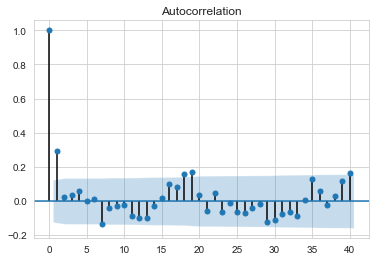

In [9]:
# Generate autocorrelation plot on training data.
plot_acf(final_differ['eur/usd'], lags = 40);

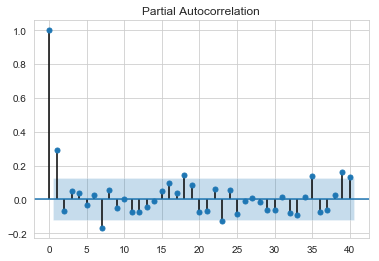

In [10]:
# Generate partial autocorrelation plot on training data.
plot_pacf(final_differ['eur/usd'], lags = 40);

Analyzing the Auto Correlation and Partial Auto Correlation chart, we notice apart from the lag 1 there's no seasonality present in the EUR/USD monthly price from Jan 99 to Dec 19

#### Create Train/Test Split

In [11]:
final_differ = final_differ.reset_index()
final_differ["date"] = pd.to_datetime(final_differ["date"])
final_differ = final_differ.set_index("date")
final_differ.index

DatetimeIndex(['1999-02-28', '1999-03-31', '1999-04-30', '1999-05-31',
               '1999-06-30', '1999-07-31', '1999-08-31', '1999-09-30',
               '1999-10-31', '1999-11-30',
               ...
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=251, freq=None)

In [12]:
# Arrange the last 6 months for prediction data
# Create a 80:20 train/test split on the remaining data sets
train = final_differ.iloc[:198]
test = final_differ.iloc[198:]
# forecast = final_differ.iloc[245:]

In [13]:
# Display the shape of the data set
print(train.shape)
print(test.shape)
# print(forecast.shape)

(198, 15)
(53, 15)


In [14]:
# # Date index got switched to object after Dicky Fueller, reset the index to datetime
# train = train.reset_index()
# train["date"] = pd.to_datetime(train["date"])
# train = train.set_index("date")
# train.index

In [15]:
# # Date index got switched to object after Dicky Fueller, reset the index to datetime
# test = test.reset_index()
# test["date"] = pd.to_datetime(test["date"])
# test = test.set_index("date")
# test.index

### Modeling

#### ARIMA

In [16]:
# Run auto arima to identify p, q with the best AIC score
auto_arima(train['eur/usd'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  198
Model:                     ARMA(0, 1)   Log Likelihood                 422.125
Method:                       css-mle   S.D. of innovations              0.029
Date:                Mon, 29 Jun 2020   AIC                           -838.250
Time:                        15:14:03   BIC                           -828.385
Sample:                             0   HQIC                          -834.257
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.145      0.885      -0.006       0.005
ma.L1.y        0.3278      0.066      4.963      0.000       0.198       0.457
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.0504           +0.0000j            3.0504            0.5000
-----------------------------------------------------------------------------
"""

In [17]:
# Instantiate an AR(1) model on training data.
# Start at time period 198 and end at 244.
ar1 = ARIMA(endog = train['eur/usd'],
            order = (0, 1, 1)) # (p, d, q)

# Fit AR(1) model.
model_ar1 = ar1.fit()

# Generate predictions based on test set.
# Start at time period 198 and end at 244.
preds = model_ar1.predict(start=198, end=250)

# Evaluate predictions.
print(mse(test['eur/usd'], preds))
print(rmse(test['eur/usd'], preds))

0.0002800809062165083
0.016735617891685633


C:\Users\Roshrav\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Roshrav\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


C:\Users\Roshrav\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


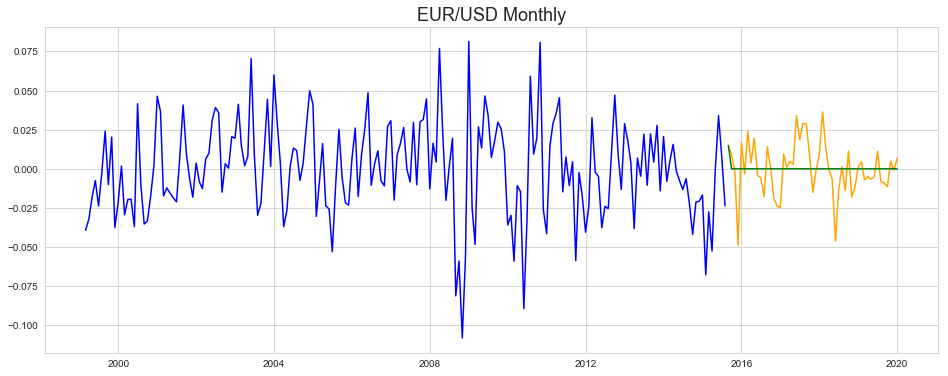

In [18]:
# Plot data.
plt.figure(figsize=(16,6))
# Plot training data in blue.
plt.plot(train['eur/usd'], color = 'blue')
# Plot testing data in orange.
plt.plot(test['eur/usd'], color = 'orange')
# Plot predicted values in green.
plt.plot(preds, color = 'green')
# Plot title
plt.title(label = 'EUR/USD Monthly', fontsize=18)
plt.show();

#### SARIMAX - Endogenous

In [19]:
# Plot SARIMAX model with Endogenous variable only
model_s1 = SARIMAX(train['eur/usd'],order=(0,1,1),seasonal_order=(0,0,0,0),enforce_invertibility=False)
results = model_s1.fit()
results.summary()

C:\Users\Roshrav\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Roshrav\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                eur/usd   No. Observations:                  198
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 407.420
Date:                Mon, 29 Jun 2020   AIC                           -810.840
Time:                        15:14:03   BIC                           -804.274
Sample:                    02-28-1999   HQIC                          -808.182
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0537      0.023    -44.920      0.000      -1.100      -1.008
sigma2         0.0008   7.61e-05     10.950      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       90.91   Jarque-Bera (JB):                11.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.25
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Obtain predicted values
start=198
end=252
predictions = results.predict(start=start, end=end, dynamic=False).rename('ARIMA(0,1,1) Predictions')

0.0002800809062165083
0.016735617891685633


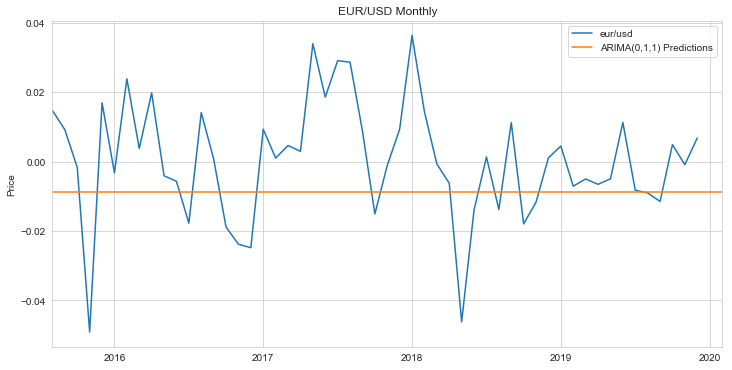

In [21]:
# Plot predictions against known test values
title='EUR/USD Monthly'
ylabel='Price'
xlabel=''

ax = test['eur/usd'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
# Evaluate predictions.
print(mse(test['eur/usd'], preds))
print(rmse(test['eur/usd'], preds))

- SARIMA model is showing the same MSE and RMSE score as ARIMA model
- This score also shows the data set not being seasonal 

#### SARIMAX - Exogenous Variables

In [22]:
# Run auto arima to identify p, q with the best AIC score, this time with exogenous variable
auto_arima(train['eur/usd'], exogenous=train[['wti_crude', 'usd_index', 'usd/chf']],seasonal=False).summary()

C:\Users\Roshrav\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\Roshrav\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  198
Model:                     ARMA(2, 2)   Log Likelihood                 649.107
Method:                       css-mle   S.D. of innovations              0.009
Date:                Mon, 29 Jun 2020   AIC                          -1280.214
Time:                        15:14:08   BIC                          -1250.619
Sample:                             0   HQIC                         -1268.235
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.279      0.781      -0.002       0.001
x1             0.0004      0.000      3.263      0.001       0.000       0.001
x2            -0.0153      0.001    -17.754      0.000      -0.017      -0.014
x3            -0.0080      0.047     -0.168      0.866      -0.101       0.085
ar.L1.y       -1.3088      0.178     -7.335      0.000      -1.659      -0.959
ar.L2.y       -0.4057      0.159     -2.545      0.011      -0.718      -0.093
ma.L1.y        1.6110      0.146     11.033      0.000       1.325       1.897
ma.L2.y        0.7062      0.131      5.383      0.000       0.449       0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2430           +0.0000j            1.2430            0.5000
AR.2           -1.9831           +0.0000j            1.9831            0.5000
MA.1           -1.1405           -0.3394j            1.1899           -0.4540
MA.2           -1.1405           +0.3394j            1.1899            0.4540
-----------------------------------------------------------------------------
"""

In [23]:
# Plot SARIMAX with top 3 exogenous features
model_s2 = SARIMAX(train['eur/usd'],exog=train[['wti_crude', 'usd_index', 'usd/chf']],order=(2,1,2),seasonal_order=(0,0,0,0),enforce_invertibility=False)
results = model_s2.fit()
results.summary()

C:\Users\Roshrav\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Roshrav\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Roshrav\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                eur/usd   No. Observations:                  198
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 639.994
Date:                Mon, 29 Jun 2020   AIC                          -1263.988
Time:                        15:14:09   BIC                          -1237.722
Sample:                    02-28-1999   HQIC                         -1253.355
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wti_crude      0.0004    9.7e-05      4.406      0.000       0.000       0.001
usd_index     -0.0155      0.001    -21.466      0.000      -0.017      -0.014
usd/chf        0.0045      0.040      0.114      0.910      -0.074       0.083
ar.L1         -0.2770      0.429     -0.646      0.518      -1.117       0.563
ar.L2          0.0290      0.152      0.191      0.848      -0.268       0.326
ma.L1         -0.4520      4.812     -0.094      0.925      -9.884       8.980
ma.L2         -0.5481      2.624     -0.209      0.835      -5.692       4.596
sigma2      8.628e-05      0.000      0.209      0.834      -0.001       0.001
===================================================================================
Ljung-Box (Q):                       26.48   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.95   Prob(JB):                         0.48
Heteroskedasticity (H):               0.98   Skew:                            -0.05
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Use test values with top 3 features for predictions
start=198
end=250
exog_forecast = test[['wti_crude', 'usd_index', 'usd/chf']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(2,1,2) Predictions')

[Text(0, 0.5, 'Price Difference'), Text(0.5, 0, '')]

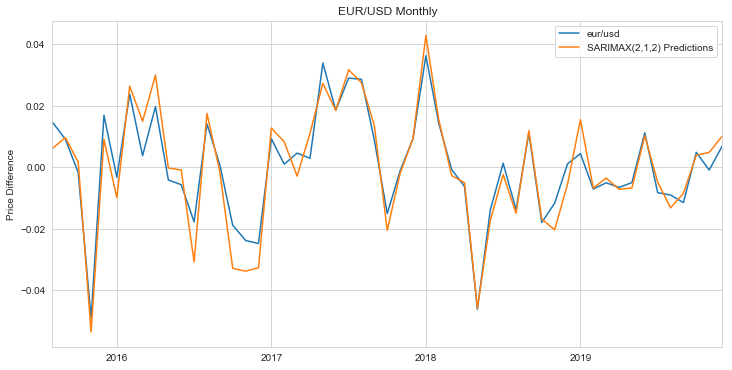

In [25]:
# Plot predictions against known values
title='EUR/USD Monthly'
ylabel='Price Difference'
xlabel=''

ax = test['eur/usd'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

#### Evaluation

In [26]:
# Evaluate the model
mean_square = mse(test['eur/usd'], predictions)
rmse_eval = rmse(test['eur/usd'], predictions)

print(f'SARIMA(2,1,2) MSE Error: {mean_square}')
print(f'SARIMA(2,1,2) RMSE Error: {rmse_eval}')
print()

SARIMA(2,1,2) MSE Error: 3.269522731387091e-05
SARIMA(2,1,2) RMSE Error: 0.005717974056767913



In [27]:
model_s3 = SARIMAX(final_differ['eur/usd'],exog=final_differ[['wti_crude', 'usd_index', 'usd/chf']],order=(2,1,2),seasonal_order=(0,0,0,0),enforce_invertibility=False)
results = model_s3.fit()
results.summary()

C:\Users\Roshrav\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Roshrav\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                eur/usd   No. Observations:                  251
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 817.434
Date:                Mon, 29 Jun 2020   AIC                          -1618.867
Time:                        15:14:09   BIC                          -1590.696
Sample:                    02-28-1999   HQIC                         -1607.529
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wti_crude      0.0003   9.13e-05      3.697      0.000       0.000       0.001
usd_index     -0.0154      0.001    -25.830      0.000      -0.017      -0.014
usd/chf        0.0084      0.032      0.259      0.796      -0.055       0.072
ar.L1         -0.3744      0.265     -1.414      0.157      -0.893       0.144
ar.L2         -0.0617      0.122     -0.504      0.614      -0.301       0.178
ma.L1         -0.1774      0.255     -0.696      0.487      -0.677       0.322
ma.L2         -0.4078      0.231     -1.762      0.078      -0.862       0.046
sigma2      8.441e-05   7.27e-06     11.613      0.000    7.02e-05    9.87e-05
===================================================================================
Ljung-Box (Q):                       39.41   Jarque-Bera (JB):                14.81
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# Use test values with top 3 features for predictions
start=245
end=250
exog_forecast = final_differ[245:][['wti_crude', 'usd_index', 'usd/chf']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(2,1,2) Predictions')

In [29]:
# final_differ = final_differ.reset_index()
# final_differ["date"] = pd.to_datetime(final_differ["date"])
# final_differ = final_differ.set_index("date")
# final_differ.index

[Text(0, 0.5, 'Price Difference'), Text(0.5, 0, '')]

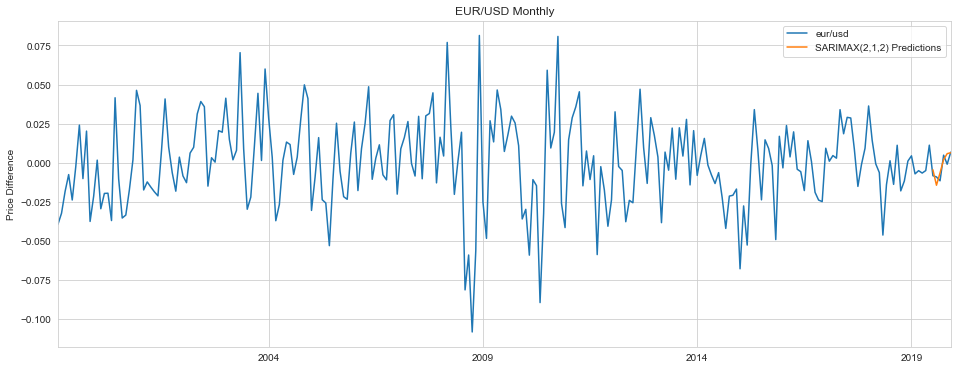

In [30]:
ax = final_differ['eur/usd'].plot(legend=True,figsize=(16,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [31]:
predicted_values = predictions

In [32]:
actual_values = final_differ.iloc[245:]['eur/usd']

In [33]:
predicted_df = actual_values.to_frame().join(predicted_values)
predicted_df['difference'] = abs(predicted_df['eur/usd'] - predicted_df['SARIMAX(2,1,2) Predictions'])

In [34]:
predicted_df.head()

,eur/usd,"SARIMAX(2,1,2) Predictions",difference
date,,,
2019-07-31,-0.008249,-0.004461,0.003788
2019-08-31,-0.009032,-0.014339,0.005307
2019-09-30,-0.011492,-0.006487,0.005005
2019-10-31,0.004868,0.002061,0.002807
2019-11-30,-0.000906,0.005841,0.006747


#### Conclusion and Recommendation

- By looking at the Arima model, we can conclude that financial data cannot be predicted just by using the endogenous variables as they tend be more sensitive with exogenous features as well. As per EDA we could see high volatility in the price in 2001 (9/11 Attacks), 2009 (Mortgage Financial Crisis) and 2016 (Brexit). Apart from Economic and Financial data, other events like Geo-Political or Natural disasters can also play a major role in determining the price.
- This was further confirmed by the MSE and RMSE score, where SARIMAX model performed way better than ARIMA at RMSE score of 0.005717974 while ARIMA RMSE scored 0.0167356 when independent variables like oil or other major currency pairs are introduced.
- I feel that this can be further improved if feature selection was used to help identify variables with higher coefficient to EUR/USD.